In [9]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit import IBMQ, transpile, execute, Aer
from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance, algorithm_globals

sns.set_theme()

In [10]:
stock_dist = np.array([
    109,145,135,132,128,138,142,124,143,134,
    134,119,132,144,135,126,133,134,147,147,
    141,138,136,133,147,137,116,127,131,150,
    145,139,130,139,138,129,144,129,141,133,
    132,
    ])

target_dist = (stock_dist - min(stock_dist)) / (max(stock_dist)-min(stock_dist)) * 7

In [27]:
def rnd_seed(backend, seed):
    algorithm_globals.random_seed = seed
    np.random.seed = seed
    quantum_instance = QuantumInstance(
        backend=backend, seed_transpiler=seed, seed_simulator=seed
    )

def get_g_circuit(round, distribution, prefix):
    entangler_map = [(0,1), (1,2)]
    init_dist = QuantumCircuit(3)
    ansatz = TwoLocal(3, ["ry", "rz", "ry"], "cx", entanglement=entangler_map, reps=1)
    npy_name = f"{prefix}_round{round}.npy"
    init_params = np.load(npy_name)
    g_circuit = ansatz.compose(init_dist, front=True)
    para_dict = {}
    for i in range(len(g_circuit.parameters)):
        para_dict[g_circuit.parameters[i]] = init_params[i]
    g_circuit = g_circuit.bind_parameters(para_dict)
    return g_circuit

distribution = "stock"
prefix = f"{distribution}/result_U_HFalse_{distribution}_r50_e3_reps1"
backend = Aer.get_backend('qasm_simulator')
entropy_dict = np.load(f"{prefix}_entropy.npy", allow_pickle=True).item()
entropy_dict = {k: v for k, v in sorted(entropy_dict.items(), key=lambda item: item[1])}
entropy_item = list(entropy_dict.items())

i = 0
round_idx = re.search("round", entropy_item[i][0]).start() + 5
round = entropy_item[i][0][round_idx:]

print(f"Round {round} : Entropy = {entropy_item[i][1]}")
rnd_seed(backend, seed=round)
qc = get_g_circuit(round, distribution, prefix)
qc.measure_all()

job = execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts()
counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[0])}
counts = list(counts.values())
counts = np.array(counts) / sum(counts)

Round 41 : Entropy = 0.1492


array([0.06542969, 0.00390625, 0.05859375, 0.26171875, 0.20410156,
       0.21875   , 0.12890625, 0.05859375])

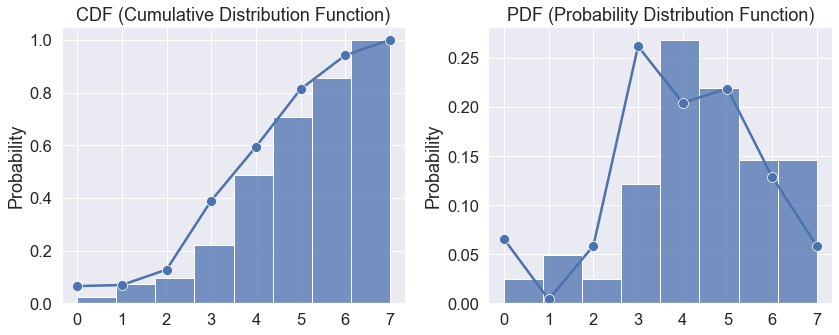

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(6*2, 5))

# Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
sns.set(font_scale=1.5)
sns.histplot(target_dist, bins=8, stat="probability", ax=ax[0], cumulative=True)
sns.histplot(target_dist, bins=8, stat="probability", ax=ax[1])
sns.lineplot(x=range(8), y=np.cumsum(counts), ax=ax[0], marker="o", linewidth=2.5, markersize=10)
sns.lineplot(x=range(8), y=counts, ax=ax[1], marker="o", linewidth=2.5, markersize=10)
ax[0].set_title("CDF (Cumulative Distribution Function)")
ax[1].set_title("PDF (Probability Distribution Function)")
ax[0].set_xticks(range(8))
ax[1].set_xticks(range(8))
plt.tight_layout()